# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [2]:
!git clone https://github.com/mashamochalina/cvr_course.git

Cloning into 'cvr_course'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 534 (delta 0), reused 0 (delta 0), pack-reused 530
Receiving objects: 100% (534/534), 76.23 MiB | 30.60 MiB/s, done.
Resolving deltas: 100% (138/138), done.


In [3]:
cd cvr_course/notebooks

/content/cvr_course/notebooks


#Task1

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m49s487.png


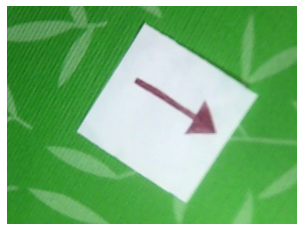

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m33s362.png


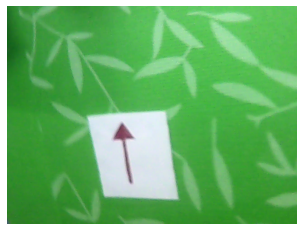

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m44s163.png


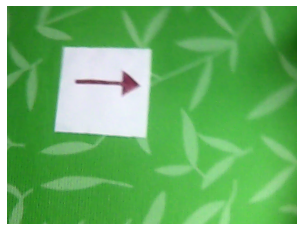

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m29s941.png


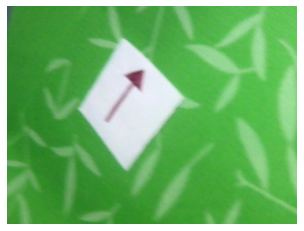

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m36s056.png


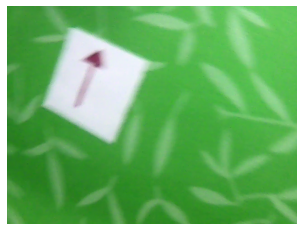

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m22s212.png


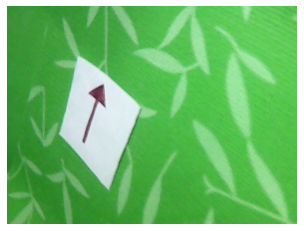

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m41s874.png


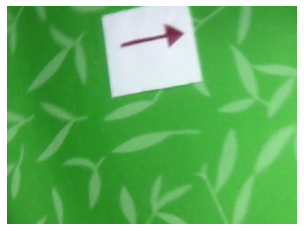

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m46s644.png


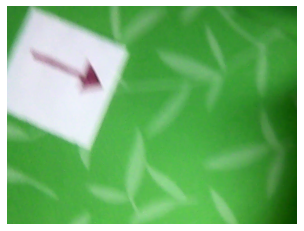

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m27s294.png


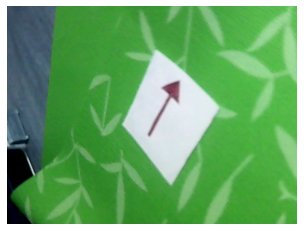

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m51s638.png


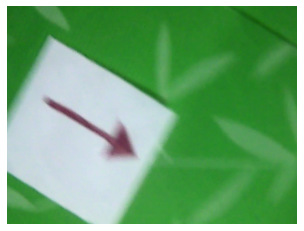

In [74]:
import numpy as np
import cv2
import glob
import time
import os
import math
import sys
from matplotlib import pyplot as plt
from PIL import Image

X_data = []
files = glob.glob ("../data/imgs/arrow/*.png")
for myFile in files:
    print(myFile)
    image = cv2.imread (myFile)
    X_data.append (image)
    plt.imshow(image)
    plt.axis ('off')
    plt.show ()

**Color space conversion**

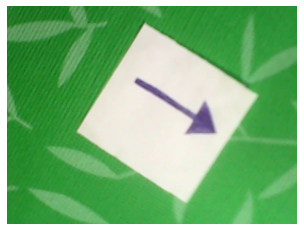

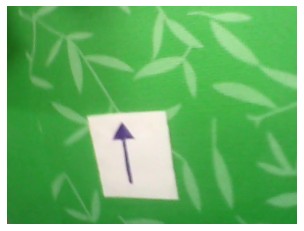

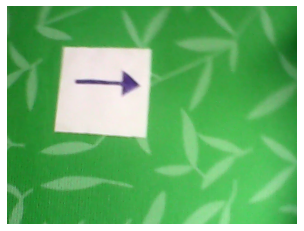

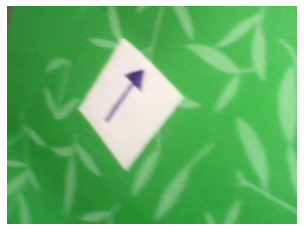

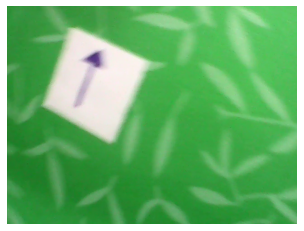

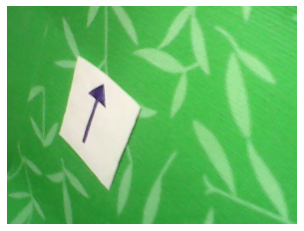

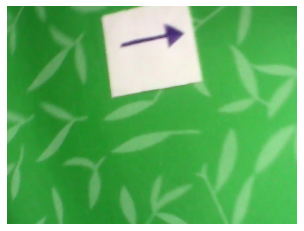

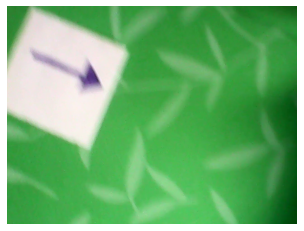

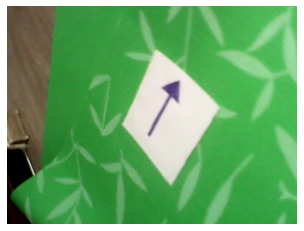

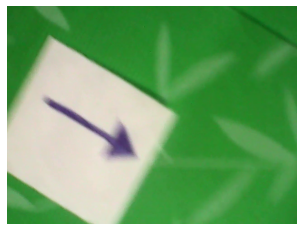

In [75]:
X2_data = []
for img in X_data:
  img_rgb = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)
  X2_data.append (img_rgb)
  plt.imshow (img_rgb)
  plt.axis ('off')
  plt.show ()

#Task3
Mask obtainment

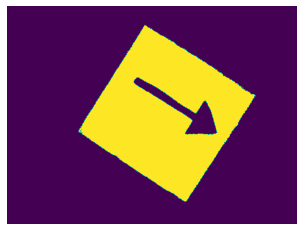

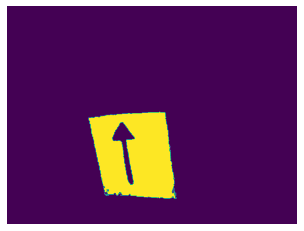

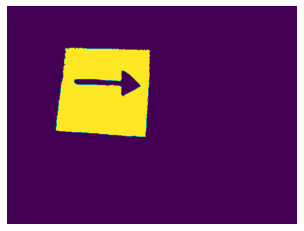

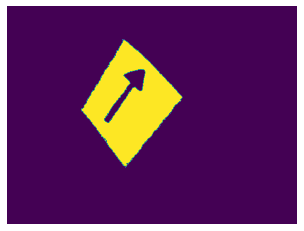

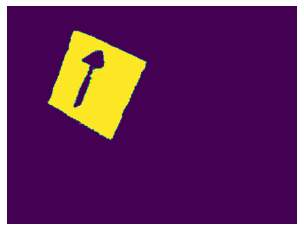

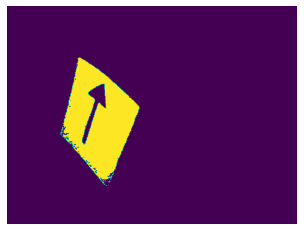

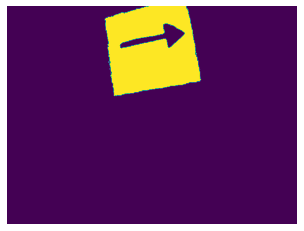

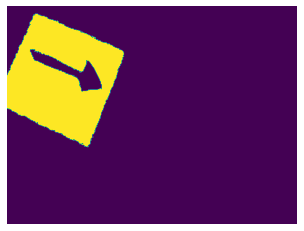

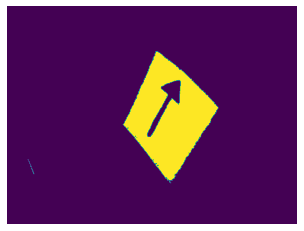

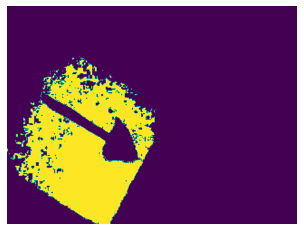

In [76]:
low_th  = (200, 200, 200)
high_th = (255, 255, 255)
mask_data = []
for img in X2_data:
  mask = cv2.inRange (img, low_th, high_th)
  mask_data.append (mask)
  plt.imshow (mask)
  plt.axis ('off')
  plt.show ()

**Contour extraction**

[[[315  99]]

 [[305 287]]

 [[108 273]]

 [[130  92]]]


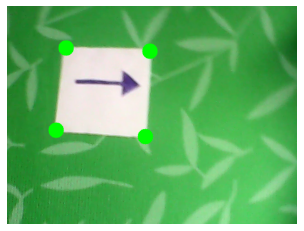

In [108]:
contours, hierarchy = cv2.findContours (mask_data[2], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours [0]

approx = cv2.convexHull (cnt)

epsilon = 0.05*cv2.arcLength (approx, True)

approx = cv2.approxPolyDP (approx, epsilon, True)

contour_marked = cv2.drawContours (X2_data[2], approx, -1, (0, 255, 0), 33)
print(approx)
plt.imshow (contour_marked)
plt.axis ('off')
plt.show ()

In [109]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    # return the ordered coordinates
    return rect

[130.  92.] [315.  99.] [305. 287.] [108. 273.]


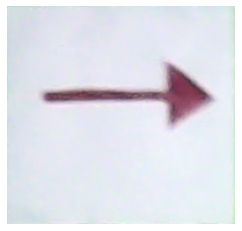

In [113]:
def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    print(tl, tr, br, bl)

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

warped = four_point_transform (X_data[2], np.asarray(approx) [:, 0, :])
plt.imshow (warped)
plt.axis ('off')
plt.show ()

#Task3
Distance approximation

In [114]:
import numpy as np
import cv2
import time
import os
import math
import sys
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

def find_contour (img, low_th, high_th):
    img_rgb = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.inRange (img, low_th, high_th)
    
    contours, hierarchy = cv2.findContours (mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours [0]

    approx = cv2.convexHull (cnt)

    epsilon = 0.05 * cv2.arcLength (approx, True)
    approx = cv2.approxPolyDP (approx, epsilon, True)

    return approx

In [121]:
def find_distance (img):
    low_th  = (200, 200, 200)
    high_th = (255, 255, 255)

    contour = find_contour (img, low_th, high_th)
    
    length = cv2.arcLength (contour, True)
    
    print (contour)

    distance = 180.0 * 364 / length
    
    return distance

In [126]:
img = X_data[4]
dist = find_distance (img)
print (dist)

[[[161 259]]

 [[160 259]]

 [[160 258]]

 [[161 258]]]
16380.0
